In [ ]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
#from keras.models import Sequential
from keras.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
import yfinance as yf

In [ ]:
# Import Starbucks stock prices from Yahoo! Finance
data = yf.download('NVDA')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376255,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415672,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383422,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382227,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381033,22752000
...,...,...,...,...,...,...
2024-01-12,546.200012,549.700012,543.299988,547.099976,547.099976,35247900
2024-01-16,550.179993,568.349976,549.000000,563.820007,563.820007,44958000
2024-01-17,563.469971,564.710022,547.400024,560.530029,560.530029,47439400


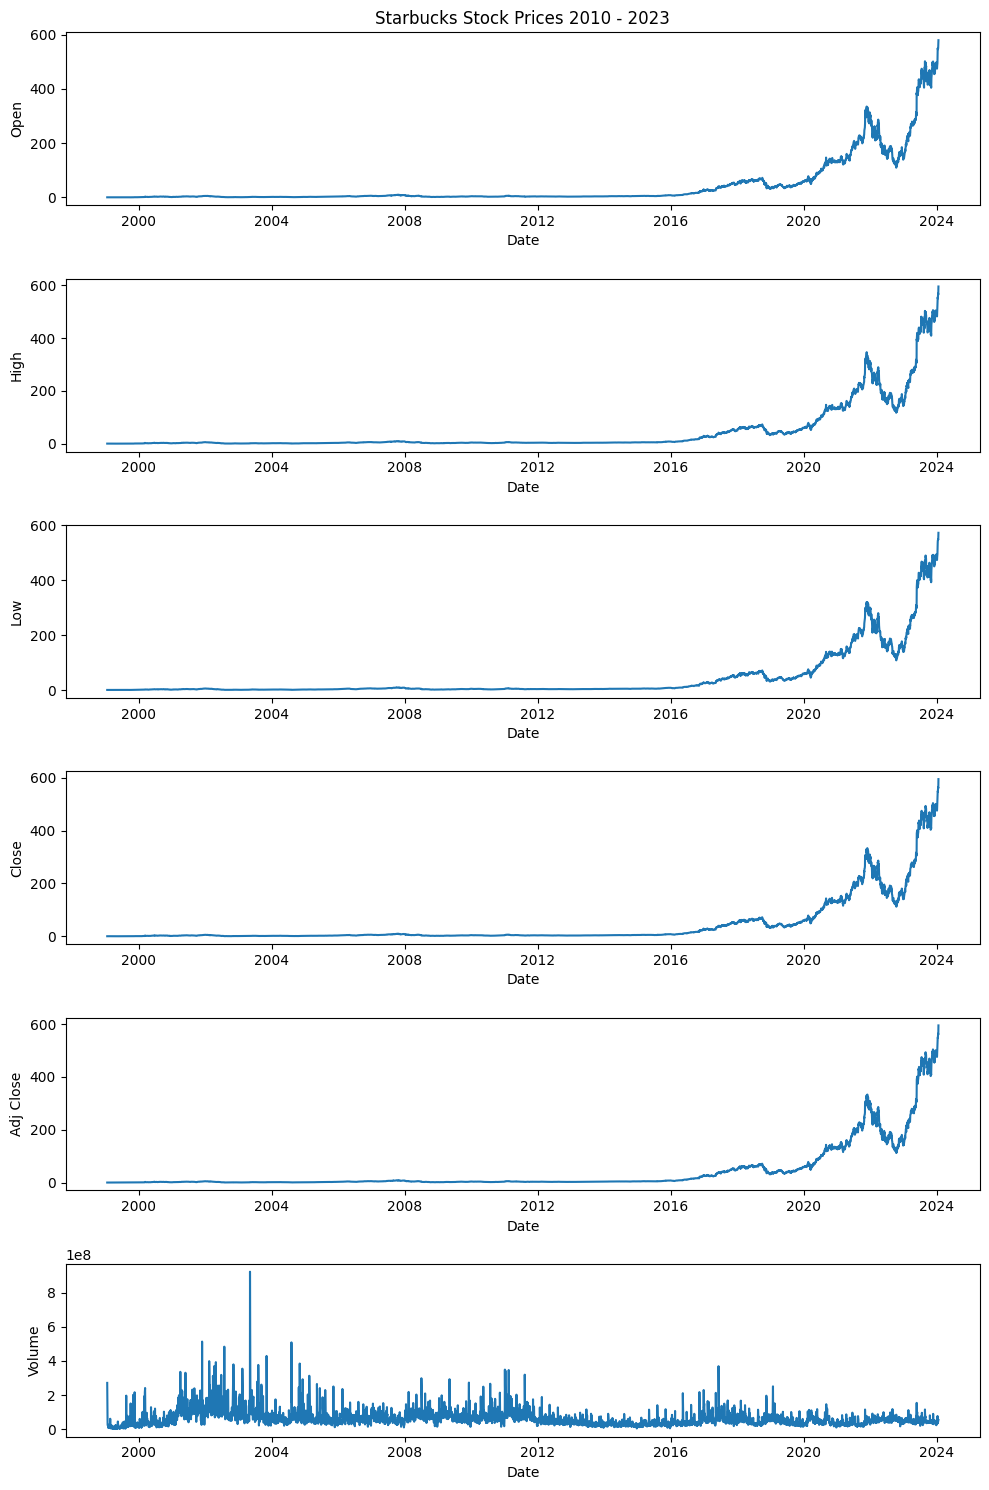

In [ ]:

def plot_col(df):
  num_cols = len(df.columns)
  fig, ax = plt.subplots(num_cols, figsize=(10, 2.5*num_cols))
  for i, column in enumerate(df.columns):
    sns.lineplot(ax=ax[i], data=df, x=df.index, y=column)
    ax[0].set_title('Starbucks Stock Prices 2010 - 2023')
  plt.tight_layout()
  plt.show()

plot_col(data)

<Axes: xlabel='Date', ylabel='Close'>

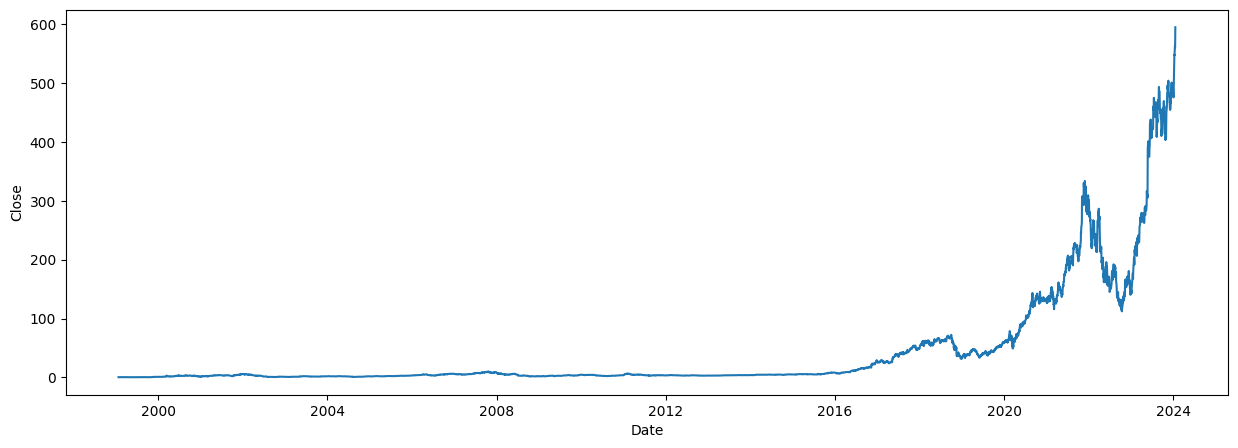

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Close'])

In [ ]:
#Split the data into training and test
split_time = '2021-01-01'
train_data = data.loc[:split_time]
test_data = data.loc[split_time:]

In [ ]:
split_time = '2016-01-01'

data = data.loc[split_time:]

split_time = '2021-01-01'
train_data = data.loc[:split_time]
test_data = data.loc[split_time:]

In [ ]:

train_close_data = train_data['Close']
valid_close_data = test_data['Close']

print(f'Train Closed Data \n{train_close_data.head()}\n')
print(f'Validation Closed Data \n{valid_close_data.head()}\n')

Train Closed Data 
Date
2016-01-04    8.0925
2016-01-05    8.2225
2016-01-06    7.8825
2016-01-07    7.5700
2016-01-08    7.4075
Name: Close, dtype: float64

Validation Closed Data 
Date
2021-01-04    131.134995
2021-01-05    134.047501
2021-01-06    126.144997
2021-01-07    133.440002
2021-01-08    132.767502
Name: Close, dtype: float64



In [ ]:
# model

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


window_size=30
train_set = window_dataset(train_close_data, window_size)
valid_set = window_dataset(valid_close_data, window_size)

#Model building
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer= keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

#Model Compiling
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

#Model Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch /30)
)

history = model.fit(train_set, epochs=200,
                    validation_data=valid_set,
                    callbacks=[early_stopping,lr_schedule])

Epoch 1/200
39/39 [==============================] - 3s 49ms/step - loss: 92.2780 - mae: 92.7780 - val_loss: 398.6665 - val_mae: 399.1665 - lr: 1.0000e-06
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 64.1700 - mae: 64.6700 - val_loss: 243.2420 - val_mae: 243.7420 - lr: 1.0798e-06
Epoch 3/200
39/39 [==============================] - 0s 7ms/step - loss: 32.1933 - mae: 32.6931 - val_loss: 78.5240 - val_mae: 79.0235 - lr: 1.1659e-06
Epoch 4/200
39/39 [==============================] - 0s 7ms/step - loss: 6.7700 - mae: 7.2434 - val_loss: 32.0575 - val_mae: 32.5549 - lr: 1.2589e-06
Epoch 5/200
39/39 [==============================] - 0s 7ms/step - loss: 4.4087 - mae: 4.8722 - val_loss: 31.0965 - val_mae: 31.5949 - lr: 1.3594e-06
Epoch 6/200
39/39 [==============================] - 0s 7ms/step - loss: 4.3681 - mae: 4.8331 - val_loss: 30.7132 - val_mae: 31.2101 - lr: 1.4678e-06
Epoch 7/200
39/39 [==============================] - 0s 7ms/step - loss: 4.3455 - mae: 4

54


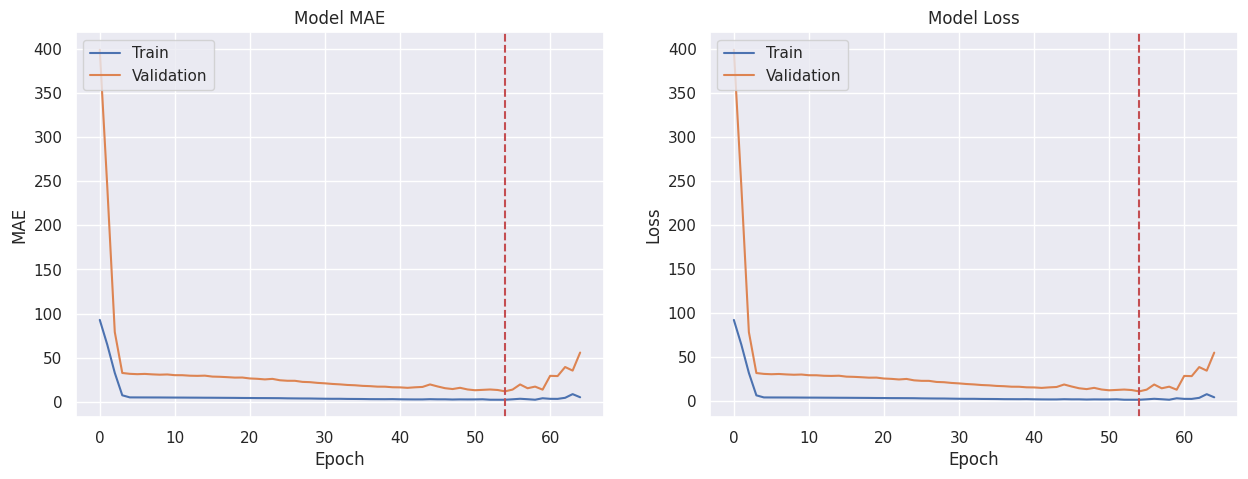

In [ ]:
def plot_history(history):
  sns.set()
  fig, axs = plt.subplots(1,2, figsize=(15,5))
  axs[0].plot(history.history['mae'])
  axs[0].plot(history.history['val_mae'])
  axs[0].set_title('Model MAE')
  axs[0].set_ylabel('MAE')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_mae'])
  axs[0].axvline(x=best_epoch, color='r', linestyle='--')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train','Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_loss'])
  print(best_epoch)
  axs[1].axvline(x=best_epoch, color='r', linestyle='--')

  plt.show()


plot_history(history)


In [ ]:

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
forecast = model_forecast(model, valid_close_data, window_size)[:, 0]
forecast


24/24 [==============================] - 0s 5ms/step


array([149.09608 , 148.72917 , 152.69202 , 149.50938 , 158.7533  ,
       150.03065 , 153.25557 , 149.61192 , 138.83635 , 144.4547  ,
       136.31772 , 137.56448 , 133.53647 , 134.41324 , 131.7522  ,
       124.52347 , 127.18994 , 124.00971 , 122.27608 , 131.10413 ,
       124.095055, 131.62865 , 135.85057 , 124.59001 , 137.81438 ,
       125.42908 , 128.97792 , 129.28592 , 131.49487 , 133.11497 ,
       131.40094 , 131.54266 , 134.13884 , 134.8169  , 138.61636 ,
       130.418   , 139.13951 , 146.15848 , 150.7209  , 154.97946 ,
       150.84604 , 154.08075 , 159.37773 , 158.21648 , 156.78984 ,
       160.22362 , 157.99187 , 158.42084 , 157.49075 , 152.8855  ,
       154.62787 , 155.28271 , 159.3624  , 153.8529  , 157.13112 ,
       150.9223  , 149.55635 , 149.54608 , 141.99347 , 142.22539 ,
       149.74419 , 144.22684 , 146.29445 , 144.89209 , 139.82773 ,
       136.34845 , 141.96143 , 138.8836  , 144.77419 , 152.52313 ,
       156.00946 , 158.76704 , 157.23607 , 160.55533 , 159.529

In [ ]:
forecast_df = pd.DataFrame(forecast[:-1],
                           index=valid_close_data.index[window_size:window_size+len(forecast)],
                           columns=['Forecast'])

In [ ]:

forecast_series = forecast_df['Forecast'].squeeze()
forecast_series

Date
2021-02-17    149.096085
2021-02-18    148.729172
2021-02-19    152.692017
2021-02-22    149.509384
2021-02-23    158.753296
                 ...    
2024-01-12    518.050476
2024-01-16    542.402710
2024-01-17    551.303772
2024-01-18    570.701355
2024-01-19    564.998230
Name: Forecast, Length: 736, dtype: float32

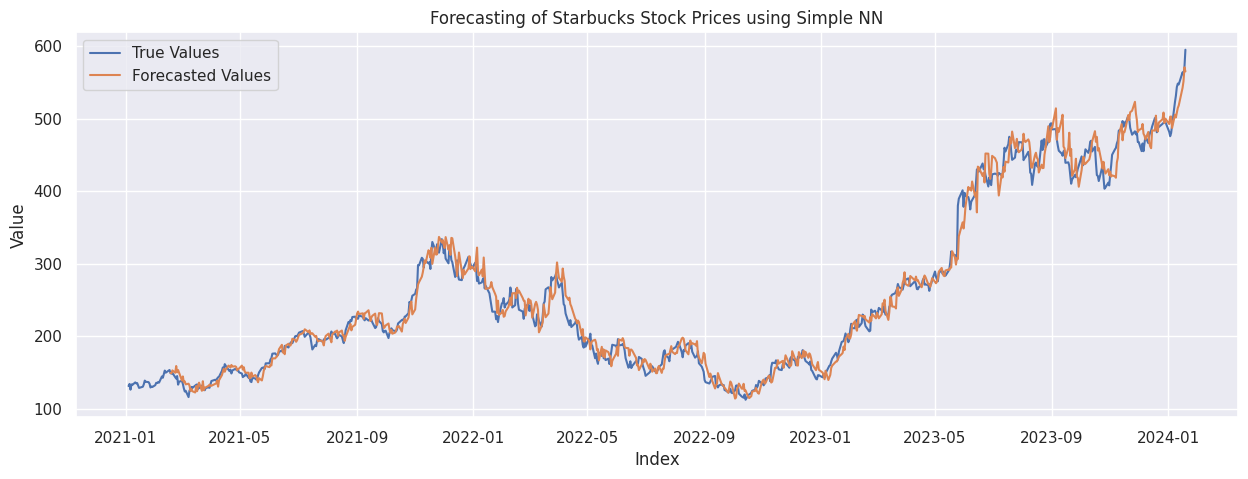

In [ ]:
def plot_predictions(y_true, y_pred):
  sns.set()
  plt.figure(figsize=(15,5))
  plt.plot(y_true, label='True Values')
  plt.plot(y_pred, label='Forecasted Values')
  plt.title('Forecasting of Starbucks Stock Prices using Simple NN')
  plt.ylabel('Value')
  plt.xlabel('Index')
  plt.legend(loc ='upper left')
  plt.show()

plot_predictions(valid_close_data, forecast_series)


In [ ]:
#Anomaly Detection

In [ ]:
!pip install adtk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00


In [ ]:

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import *

In [ ]:
data=data.reset_index()
data[['Date','Open']]

,Date,Open
0,2016-01-04,8.072500
1,2016-01-05,8.245000
2,2016-01-06,8.087500
3,2016-01-07,7.685000
4,2016-01-08,7.667500
...,...,...
2020,2024-01-12,546.200012
2021,2024-01-16,550.179993
2022,2024-01-17,563.469971
2023,2024-01-18,572.599976


In [ ]:
open_data = data[['Date','Open']]
open_data.describe()

,Open
count,2025.000000
mean,127.082520
std,124.457270
min,6.195000
25%,40.445000
50%,65.422501
75%,177.907501
max,579.890015


In [ ]:
open_data = open_data.set_index('Date')

Detector that detects anomaly based on user-given threshold
This detector compares time series with user-given thresholds, and identifies time points as anomalies when values are beyond the thresholds

Text(0.5, 1.0, 'Threshold Anomaly Detection')

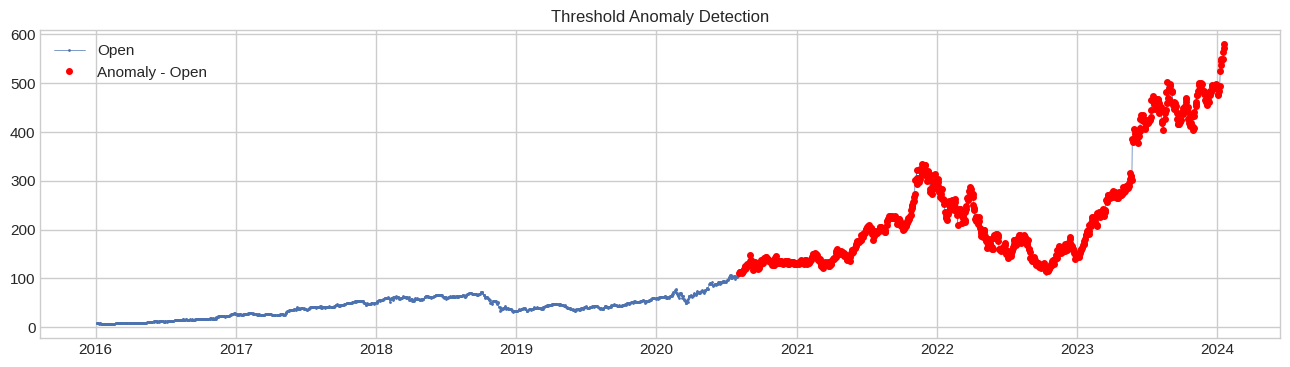

In [ ]:
#threshold detecter
threshold_detector = ThresholdAD(low=1, high=110)
anomalies = threshold_detector.detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Threshold Anomaly Detection')

quantile detector

Detects anomaly based on quantiles of historical data
Detector compares time series values with user specified quantiles of historical data, and identifies time points anomalous when values are beyond thresholds

Text(0.5, 1.0, 'Quantile Anomaly Detector')

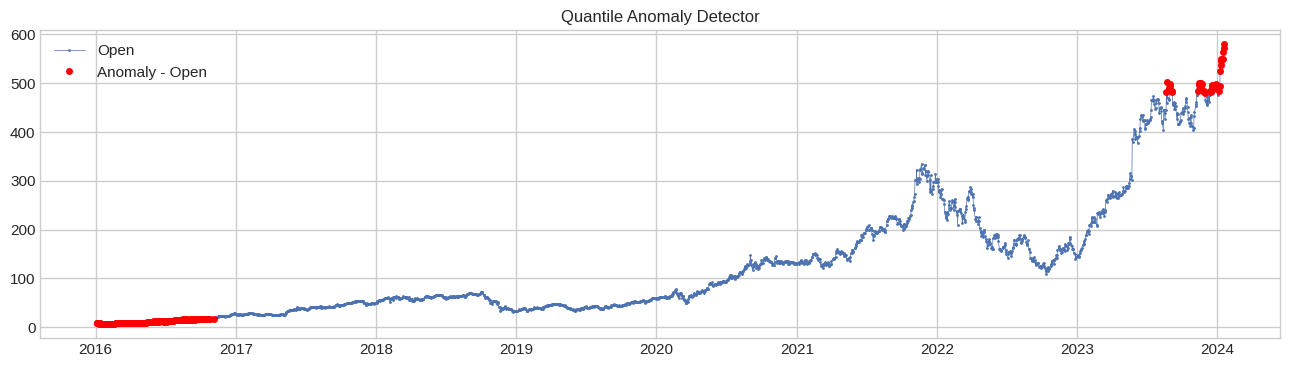

In [ ]:
quantile_detector = QuantileAD(low=0.1, high=0.98)
anomalies = quantile_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title("Quantile Anomaly Detector")

inter quartile detector

Detects anomaly based on inter-quartile range of historical data
Detector compares time series values with 1st and 3rd quartiles of historical data, identifies time points as anomalous when differences are beyond the inter-quartile range (IQR) times a user given factor c

Text(0.5, 1.0, 'Inter Quartile Range Anomaly Detection')

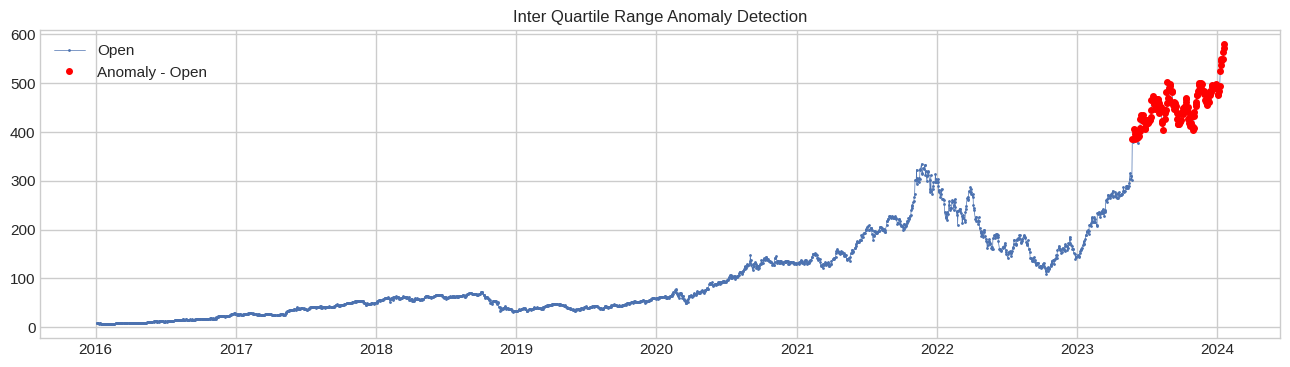

In [ ]:
iqr_detector = InterQuartileRangeAD(c=1.5)
anomalies = iqr_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Inter Quartile Range Anomaly Detection')

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

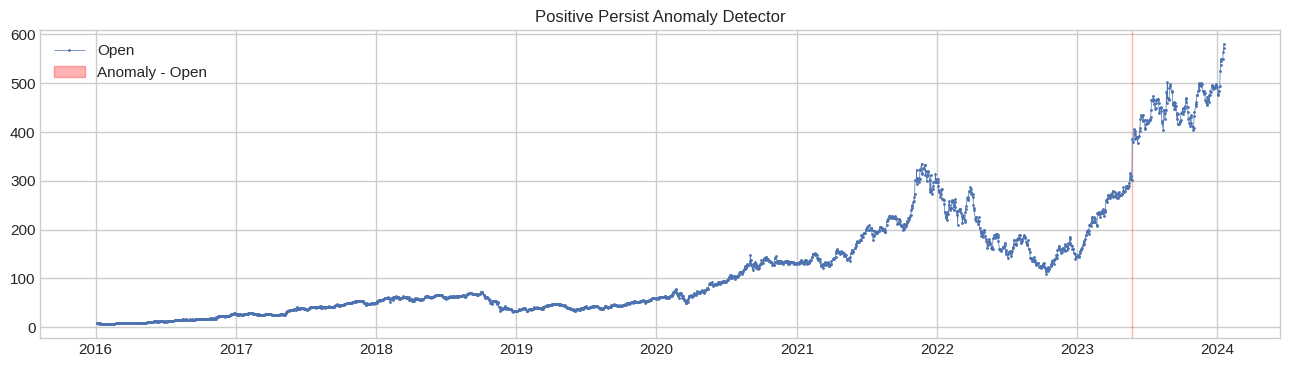

In [ ]:
persist_detector = PersistAD(c=15, side='positive')
anomalies = persist_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Positive Persist Anomaly Detector')

Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

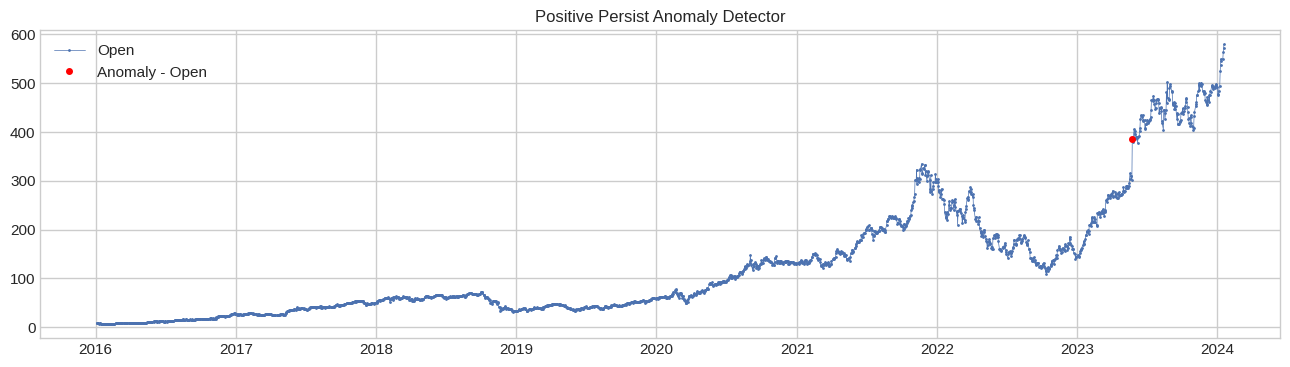

In [ ]:
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Positive Persist Anomaly Detector')

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

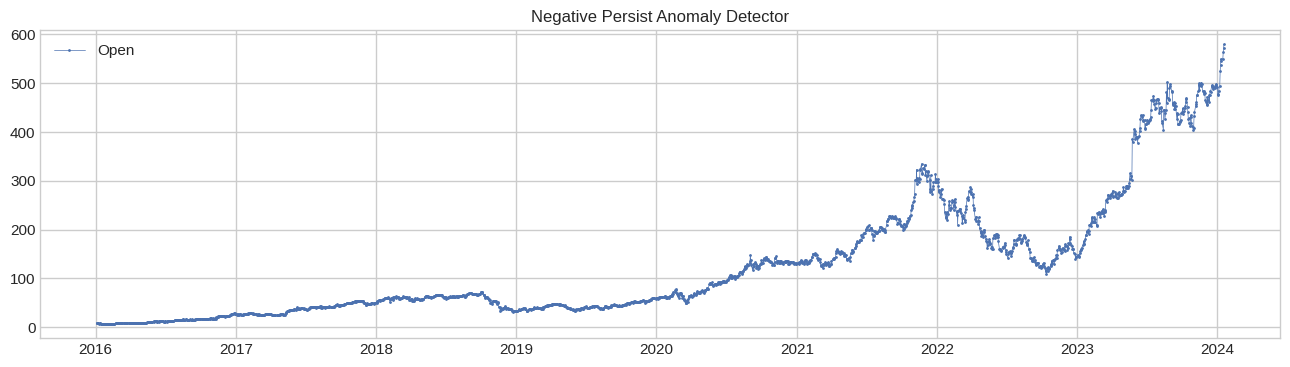

In [ ]:
persist_detector = PersistAD(c=15, side='negative')
anomalies = persist_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Negative Persist Anomaly Detector')

Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

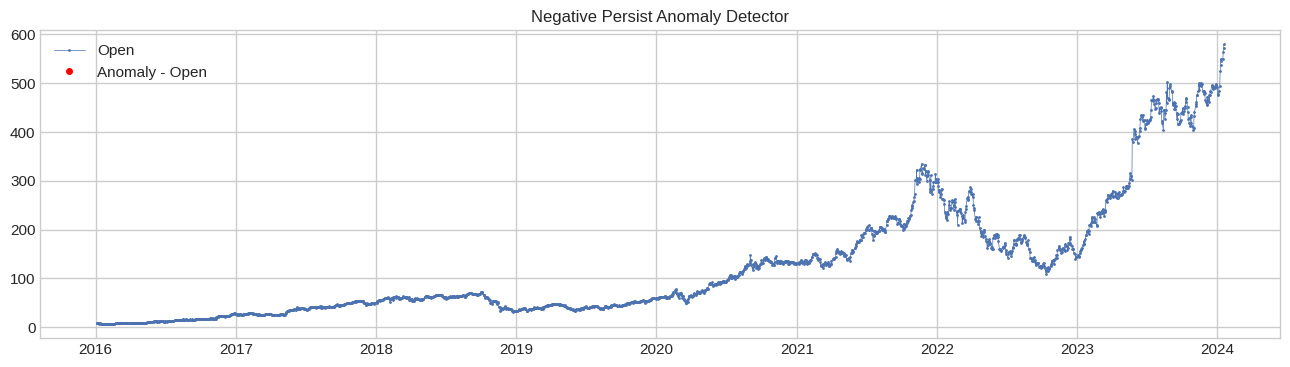

In [ ]:
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Negative Persist Anomaly Detector')

voltality detector

Detects shift of volatility in TS
Detector compares volatility of two time windows next to each other, identifies the time point in between as a volatility shift point if the difference of the volatility measurement in the two time windows is anomalously large

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


Text(0.5, 1.0, 'Volatility Anomaly Detection')

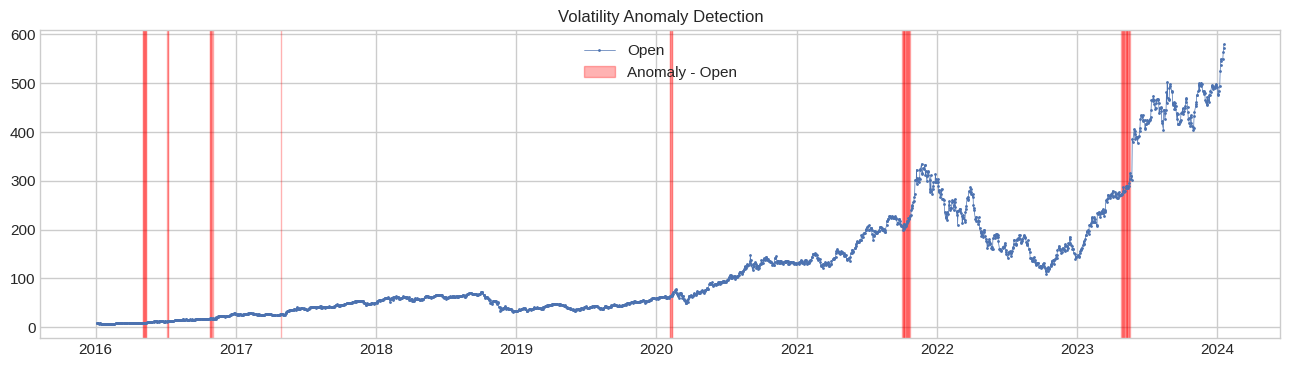

In [ ]:
volatility_detector = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red')
plt.title('Volatility Anomaly Detection')